# Module imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time

# Data

In [2]:
df = pd.read_csv('../Data/NYCTaxiFares.csv')
df.sample(5)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
85076,2010-04-21 13:37:51 UTC,4.5,0,-73.956842,40.817979,-73.964996,40.806933,1
59937,2010-04-23 15:12:22 UTC,3.7,0,-73.954589,40.783982,-73.954414,40.778517,1
4575,2010-04-21 08:24:00 UTC,8.9,0,-73.979557,40.783718,-73.994097,40.751323,1
65536,2010-04-21 07:46:44 UTC,3.3,0,-73.979849,40.765184,-73.973417,40.762488,1
58099,2010-04-19 22:08:52 UTC,9.3,0,-73.979113,40.763515,-73.993607,40.728962,1


In [3]:
df.describe()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,10.040326,0.333333,-73.976626,40.751443,-73.974501,40.751695,1.347167
std,7.500134,0.471406,0.031497,0.025821,0.032419,0.030279,0.759263
min,2.500000,0.000000,-74.465447,40.121653,-74.443323,40.164927,1.000000
25%,5.700000,0.000000,-73.992386,40.736594,-73.991478,40.735914,1.000000
50%,7.700000,0.000000,-73.982084,40.753661,-73.980411,40.754441,1.000000
75%,11.300000,1.000000,-73.968710,40.768020,-73.965500,40.768880,1.000000
max,49.900000,1.000000,-73.311845,40.981292,-73.496140,40.993498,5.000000


## Feature engineering

We will be using the Harvesine formula to calculate the distance between two sets of (lat,lon) points.

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$


In [4]:
def harvesine(df, lat1, lon1, lat2, lon2, r=6371):
    # Convert lat lon to radians
    lat1 = df[lat1].apply(np.radians)
    lon1 = df[lon1].apply(np.radians)
    lat2 = df[lat2].apply(np.radians)
    lon2 = df[lon2].apply(np.radians)
    
    delta_lat = lat2-lat1
    delta_lon = lon2-lon1
    
    a = np.sin(delta_lat/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin(delta_lon/2)**2
    b = np.sqrt(a)
    return 2*r*np.arcsin(b)

In [5]:
# Calculating the distance between pick-up and drop-off
df['dist_kms'] = harvesine(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')

Converting dates to datetime objects in python

In [6]:
# Convert date to dateime object
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

Modifying dates to make sure they reflect the time where the event happened and extracting useful features from the original datetime object.

In [7]:
# Create date on timezone where the events happened - EDT
#df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)
df['edt_date'] = df['pickup_datetime'].dt.tz_convert('US/Eastern')

In [8]:
# Extract features from datetime object
df['pickup_hour'] = df['edt_date'].dt.hour
df['pickup_ampm'] = df['pickup_hour'].apply(lambda x: 'am' if x<12 else 'pm')
df['pickup_weekday'] = df['edt_date'].dt.strftime("%a")
df['pickup_day'] = df['edt_date'].dt.day

In [9]:
df.sample(5)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_kms,edt_date,pickup_hour,pickup_ampm,pickup_weekday,pickup_day
14314,2010-04-16 20:20:29+00:00,9.3,0,-73.986759,40.739547,-73.968586,40.770407,1,3.757414,2010-04-16 16:20:29-04:00,16,pm,Fri,16
111699,2010-04-11 13:48:27+00:00,4.1,0,-73.961346,40.771643,-73.967859,40.762605,1,1.144916,2010-04-11 09:48:27-04:00,9,am,Sun,11
109381,2010-04-22 14:38:24+00:00,5.3,0,-73.966006,40.804285,-73.976526,40.790829,1,1.738654,2010-04-22 10:38:24-04:00,10,am,Thu,22
38014,2010-04-19 01:14:21+00:00,15.3,1,-73.950027,40.727792,-73.957761,40.671577,1,6.284733,2010-04-18 21:14:21-04:00,21,pm,Sun,18
25602,2010-04-19 13:29:45+00:00,8.1,0,-73.999876,40.738696,-73.988773,40.768996,1,3.496600,2010-04-19 09:29:45-04:00,9,am,Mon,19


## Defining categorical and continuous columns

We will define the columns that contain categorical and continuous variables.

In [10]:
cat_cols = ['pickup_hour', 'pickup_ampm','pickup_weekday', 'pickup_day']
cont_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','passenger_count', 'dist_kms']

Define the target variable that we will be regressing to.

In [11]:
y_col = ['fare_amount']

Modify the data type of categorical values to a category data type

In [12]:
for c in cat_cols:
    df[c] = df[c].astype('category')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype                     
---  ------             --------------   -----                     
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]       
 1   fare_amount        120000 non-null  float64                   
 2   fare_class         120000 non-null  int64                     
 3   pickup_longitude   120000 non-null  float64                   
 4   pickup_latitude    120000 non-null  float64                   
 5   dropoff_longitude  120000 non-null  float64                   
 6   dropoff_latitude   120000 non-null  float64                   
 7   passenger_count    120000 non-null  int64                     
 8   dist_kms           120000 non-null  float64                   
 9   edt_date           120000 non-null  datetime64[ns, US/Eastern]
 10  pickup_hour        120000 non-null  category                  
 11  

In [14]:
df['pickup_hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: pickup_hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

We can explore the categories and the code that has been assigned by pandas.

In [15]:
# Review the categories of the variable
df['pickup_ampm'].cat.categories

Index(['am', 'pm'], dtype='object')

In [16]:
# Review the codes of the categories
df['pickup_ampm'].cat.codes

0         0
1         0
2         0
3         1
4         1
         ..
119995    0
119996    0
119997    1
119998    0
119999    1
Length: 120000, dtype: int8

To transform these into tensors, we need to extract the variables as numpy arrays and stack the variables to create a single array.

```
hr = df['pickup_hour'].cat.codes.values
ampm = df['pickup_ampm'].cat.codes.values
weekday = df['pickup_weekday'].cat.codes.values
day = df['pickup_day'].cat.codes.values

cats = np.stack([hr, ampm, weekday, day],axis=1)
```

This will create an array of shape (1200,4).

It can also be achieved with a list comprehension.

In [17]:
cats = np.stack([df[c].cat.codes.values for c in cat_cols],axis=1)
cats

array([[ 4,  0,  1,  8],
       [11,  0,  2,  6],
       [ 7,  0,  2,  6],
       ...,
       [14,  1,  3,  7],
       [ 4,  0,  5,  2],
       [12,  1,  2,  6]], dtype=int8)

Convert to a tensor

In [18]:
cats = torch.tensor(cats,dtype=torch.int64)

Convert the continuous variables into tensors

In [19]:
conts = torch.tensor(np.stack([df[c].values for c in cont_cols],axis=1),dtype=torch.float)
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])

Convert the target variable to a tensor

In [20]:
y = torch.tensor(df[y_col].values,dtype=torch.float)

In [21]:
cats.shape, conts.shape, y.shape

(torch.Size([120000, 4]), torch.Size([120000, 6]), torch.Size([120000, 1]))

## Embedding sizes

We will set the embeddings size for the categorical variables. Embeddings will be similar to one-hot encoding the variables; however embeddings give us semantic information about categorical variables.

The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [22]:
# Determining the number of categories in each categorical column
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
cat_szs

[24, 2, 7, 14]

In [23]:
# Create the embedding sizes for each of the cat cols
emb_szs = [(size,min(50,size+1)//2) for size in cat_szs] # Add 1 to sizes to handle entries with only 1 category
emb_szs

[(24, 12), (2, 1), (7, 4), (14, 7)]

# Defining a Tabular Module

We will be defining a module to work with tabular data that may include categorical and continous data.

The steps to define this module are:

1. Extend the base Module class to include:
    - emb_szs: list of tuples: list of categorical variables sizes paired with their embedding sizes
    - n_cont: int: number of continous variables
    - out_sz: int: output size
    - layers: list of int: list of layer sizes
    - p: list of float: dropout probability for each layer

```
class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=[0.5]):
        super().__init__()
```

2. Set up the embedded layers with `torch.nn.ModuleList()` and `torch.nn.Embedding()`. Categorical data will be filtered through the embeddings when going through the forward pass.<br>
`self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])`
where
    - `ni`: number of categories
    - `nf`: embedding dimensions

3. Set up a droput function for the embeddings with `torch.nn.Dropout()`<br>
`self.emb_drop = nn.Dropout(emb_dropout)`

4. Set up a normalisation furnction for the continious variables with `torch.nn.BatchNorm1d()`<br>
`self.bn_cont = nn.BatchNorm1d(n_cont)`

5. Set up a sequence of neural network layers where each level includes a Linear function, an activation function (ReLU), a normalisation step, and a dropout layer. We'll combine the list of layers with `torch.nn.Sequential()`

```
self.bn_cont = nn.BatchNorm1d(n_cont)
layerlist = []
n_emb = sum((nf for ni,nf in emb_szs))
n_in = n_emb + n_cont

for i in layers:
  layerlist.append(nn.Linear(n_in,i))
  layerlist.append(nn.ReLU(inplace=True))
  layerlist.append(nn.BatchNorm1d(i))
  layerlist.append(nn.Dropout(p))
  n_in = i
layerlist.append(nn.Linear(layers[-1],out_sz))

self.layers = nn.Sequential(*layerlist)
```

6. Define the forward method. Preprocess the embeddings and normalise the continous variables vefore passing them through the layers. Use `torch.cat()` to combine multiple tensors into one.

```
def forward(self, x_cat, x_cont):
    embeddings = []
    for i,e in enumerate(self.embeds):
        embeddings.append(e(x_cat[:,i]))
    x = torch.cat(embeddings, 1)
    x = self.emb_drop(x)

    x_cont = self.bn_cont(x_cont)
    x = torch.cat([x, x_cont], 1)
    x = self.layers(x)
    return x
```

## Embedding layer explained

<div class="alert alert-block alert-danger">
    Code in this section will be done inside the module through the forward pass. This section is just for explanatory purposes.
</div>

Inside the module, we will be using `[nn.Embedings(ni,nf) for ni,nf in emb_szs]` and passing that to `nn.ModuleList(...)` in the forward pass.

In [24]:
catz = cats[:2]
catz

tensor([[ 4,  0,  1,  8],
        [11,  0,  2,  6]])

In [25]:
[nn.Embedding(ni,nf) for ni,nf in emb_szs]

[Embedding(24, 12), Embedding(2, 1), Embedding(7, 4), Embedding(14, 7)]

In [26]:
selfembeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
  (3): Embedding(14, 7)
)

Inside the forward method, we will be passing our column of data through the embeddings. Each column represents one of our categorical values and it will be passed to the corresponding embedding.

For example:

`pickup_hour` has 24 categories and 12 embeddings, we will be passing the entire first row of our numpy array `catz[:,0]` through the embeddings which will create 12 values for each row in the first variable.

Passing through the embeddings the `pickup_hour` column (index 0) for two rows returns:

in: `(selfembeds[0](catz[:,0]))`

out:

```
tensor([[ 0.4035,  1.1962,  0.4452,  1.1123,  2.2838,  1.1894, -0.5491,  0.1747,
          0.4947, -1.0240, -1.8205,  0.7558],
        [-0.0905, -0.1454, -1.0825,  2.2204, -0.1853, -0.1886,  0.6096, -1.0684,
          0.0384, -1.5803,  0.2797, -0.6877]], grad_fn=<EmbeddingBackward0>)
```

in: `(selfembeds[0](catz[:,0])).shape`

out: `torch.Size([2, 12])`


In [27]:
# Creating a list of tensors, each tensor is a list of the embeddings for each row of data passed.
embeddingz = []

for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))

In [28]:
for t in embeddingz:
    print(t.shape)

torch.Size([2, 12])
torch.Size([2, 1])
torch.Size([2, 4])
torch.Size([2, 7])


In [29]:
# Concatenate all embeddings into a single tesor
z = torch.cat(embeddingz,dim=1)
z.shape

torch.Size([2, 24])

We will then pass the embeddings through a dropout layer which helps with overfitting by reducing the reliance of the network on any specific node. 

In [30]:
selfembdrop = nn.Dropout()

In [31]:
z = selfembdrop(z)

In [32]:
z

tensor([[-1.8055,  0.0000,  2.4957,  0.0000, -0.0000,  0.0000,  4.6374,  0.0000,
          0.8108,  3.5453, -0.0000, -0.6594,  2.7116, -0.0000,  0.0000, -1.5781,
          1.1200, -0.0000,  0.0000,  0.0000,  0.8199, -4.5352, -3.9665, -0.5697],
        [ 0.0000,  1.2207,  0.0597,  0.0000,  0.0000,  2.3288,  0.0000, -0.9223,
         -0.0000,  1.9005,  0.0000, -0.0000,  2.7116, -0.0000, -0.0543, -0.0000,
          0.0000,  1.2434,  0.0000, -3.3424,  0.0000,  4.3428, -0.0904, -0.0000]],
       grad_fn=<MulBackward0>)

## Tabular Model

In [33]:
class TabularModel(nn.Module):
    '''
    - emb_szs: list of tuples: list of categorical variables sizes paired with their embedding sizes
    - n_cont: int: number of continous variables
    - out_sz: int: output size
    - layers: list of int: list of layer sizes
    - p: list of float: dropout probability for each layer
    '''
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        
        # Instanciate nn.Module
        super().__init__()
        
        # Create the embedings ModuleList, dropout, and batch normalisation functions
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont) # Normalising continuous features to make sure they are in the same scale
        
        # Create the initial and hidden layers of the model
        layerlist = []
        n_emb = sum([nf for ni,nf in emb_szs])
        # Total number of in features to the neural network
        n_in = n_emb + n_cont
        
        for n,i in enumerate(layers):
            layerlist.append(nn.Linear(n_in, i))    # Apply a linear transformatino for incomming data
            layerlist.append(nn.ReLU(inplace=True)) # Apply ReLU to the data
            layerlist.append(nn.BatchNorm1d(i))     # Normalise data
            layerlist.append(nn.Dropout(p))         # Dropout nodes
            n_in = i # This parameter will set the n_in for the next layer based on the size of the existing layer
        
        # Create an output layer
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Create a sequential container for the layers
        self.layers = nn.Sequential(*layerlist)
            
        
    def forward(self, x_cat, x_cont):
        # Initiate a list of embedding tensors
        embeddings = []
                
        # Append to the embeddings list the embeddings for all categorical variables
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
            
        # Concatenate the embedings on a row basis and apply dropout
        x = torch.cat(embeddings,1)
            
        x = self.emb_drop(x)

        # Apply batch normalisation to continuous variables
        x_cont = self.bn_cont(x_cont)

        # Concatenate continuous and categorical variables
        x = torch.cat([x,x_cont], 1)

        # Output of all layers
        x = self.layers(x)
        return x

In [42]:
torch.manual_seed(33)
model = TabularModel(emb_szs=emb_szs, n_cont=conts.shape[1], 
                     out_sz=1, layers=[200,100], p=0.4)

In [43]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
    (3): Embedding(14, 7)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=30, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

## Loss function and optimiser

We will use root mean squared error (RMSE) for our loss function and Adam for our optimiser.

RMSE = `np.sqrt(nn.MSELoss())`<br>
Adam = `torch.optim.Adam(model.parameters())`

In [44]:
# Define the criterion (loss function) and the optimiser
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(),lr=0.001)

# Training the model

## Train test split

The existing dataset has 120,000 entries per batch. To speed up the training we will reduce the batch size to 60,000 entries.

In [45]:
batch_size = 60000
test_size = int(batch_size*0.2)

In [46]:
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]

In [47]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

## Training

In [48]:
training_time = time.time()

epochs = 15
losses = []

dataset_train = TensorDataset(cat_train, con_train, y_train)
data_loader = DataLoader(dataset_train,batch_size=1000,num_workers=1)

for i in range(epochs):
    i+=1
    
    batch_losses = []
    # For each epoch, for each dataset in the data loader
    for cat_train, con_train, y_train in data_loader:
        y_pred = model(cat_train, con_train)
        loss = torch.sqrt(criterion(y_pred, y_train)) #RMSE
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%5 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - training_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 10.31181717
epoch:   6  loss: 4.22650766
epoch:  11  loss: 3.83772683
epoch:  15  loss: 3.47624254

Duration: 28 seconds


## Plot the loss function

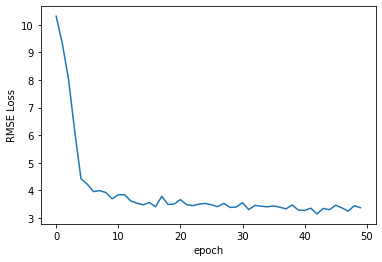

In [41]:
plt.plot(range(epochs), [l.item() for l in losses])
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

# Model evaluation

We will be evaluating the test set through the mode. To avoid updating the weights of the neural network we use `torch.no_grad()`.

In [51]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:8f}')

RMSE: 3.464063


On average, values predicted are within &plusmn;$3.46 of the actual value

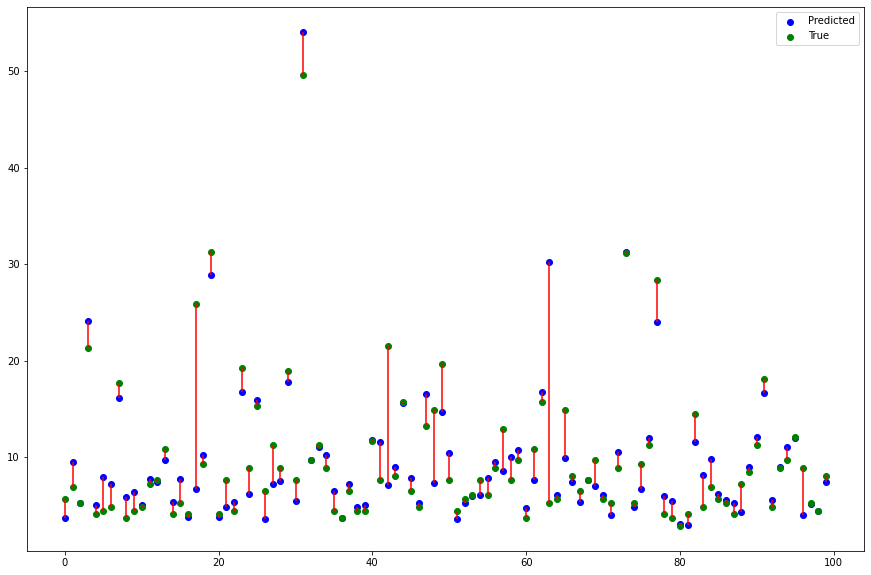

In [160]:
sample_idx = np.random.randint(0,len(y_val),100)

predictions = y_val.numpy()[sample_idx]
tests = y_test.numpy()[sample_idx]

plt.figure(figsize=(15,10))
plt.scatter(x=np.arange(len(sample_idx)), y=predictions, color='b', label='Predicted')
plt.scatter(x=np.arange(len(sample_idx)), y=tests, color='g', label='True')

for i in range(len(sample_idx)):
    plt.vlines(x=i,ymin=min(predictions[i],tests[i]),ymax=max(predictions[i],tests[i]),color='r')


plt.legend();

# Save the model

In [161]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), '2l-TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')